In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from pysm3 import units as u
import pysm3 as pysm
%matplotlib inline

In [2]:
np.random.seed(4)

In [3]:
nside = 128

In [4]:
dip = hp.synfast([0,1], lmax=1, nside=nside) * u.V

/home/zonca/zonca/p/software/healpy/healpy/sphtfunc.py:438: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,
/home/zonca/zonca/p/software/healpy/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/zonca/zonca/p/software/healpy/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


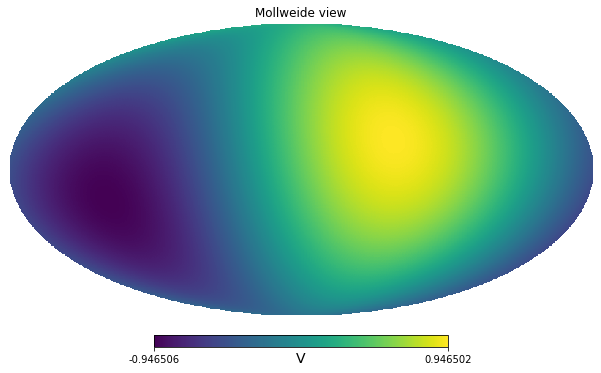

In [5]:
hp.mollview(dip, unit=dip.unit)

We measure the sky with out broadband instrument, we assume we only measure the CMB solar dipole,
initially the units are arbitrary, for example Volts of our instrument.

Next we calibrate on the solar dipole, which is known to be 3.3 mK.

In [6]:
calibration_factor = 2 * 3.3 * u.mK_CMB / (dip.max() - dip.min())

In [7]:
calibration_factor

<Quantity 3.48650905 mK_CMB / V>

In [8]:
theta, phi = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))

In [9]:
dust_amplitude_V = 2 * u.V
dust_latitude = 20 * u.deg

In [10]:
dust = dust_amplitude_V * np.logical_and(theta > (90 * u.deg - dust_latitude).to_value(u.rad),  theta < (90 * u.deg + dust_latitude).to_value(u.rad))

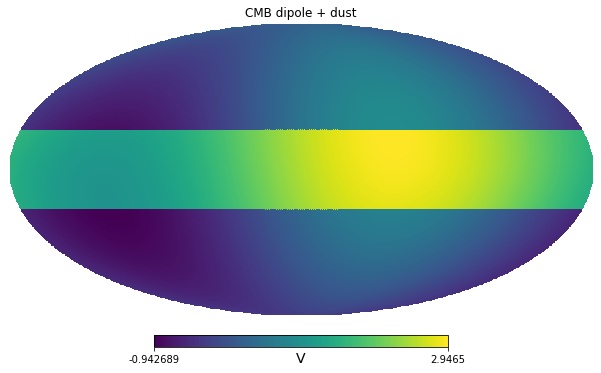

In [11]:
hp.mollview(dip + dust, unit=dip.unit, title="CMB dipole + dust")

In [12]:
calibrated_dip = calibration_factor * dip

For a delta frequency it is straightforward to compute the temperature of the dust
in any unit:

In [13]:
calibrated_dust_amplitude = dust_amplitude_V * calibration_factor

In [14]:
calibrated_dust_amplitude

<Quantity 6.97301809 mK_CMB>

First we simplify and consider a delta-frequency instrument at 300 GHz

In [15]:
center_frequency = 300 * u.GHz

In [16]:
calibrated_dust_amplitude.to(u.mK_RJ, equivalencies=u.cmb_equivalencies(center_frequency))

<Quantity 0.99846974 mK_RJ>

In [17]:
calibrated_dust_amplitude.to(u.MJy/u.sr, equivalencies=u.cmb_equivalencies(center_frequency))

<Quantity 2.76089118 MJy / sr>

## Broadband instrument

Next we assume instead that we have a broadband instrument, of 20% bandwidth, with uniform response **in power** (Spectral radiance) in that range.
For simplicity, we only take 4 points.

In [18]:
freq = [270, 290, 310, 330] * u.GHz

In [19]:
weights = [1, 1, 1, 1]

In [20]:
weights /= np.trapz(weights, freq)

In [21]:
weights

<Quantity [0.01666667, 0.01666667, 0.01666667, 0.01666667] 1 / GHz>

The instrument bandpass is defined in power so we can transform our signal in MJy/sr at the 4 reference frequencies,
then integrate.

## Dust model

Let's assume for the dust a power-law model with a spectral index of 2 (more realistic models use a modified black body), i.e.:

$I_{dust}(\nu)\left[\frac{MJy}{sr}\right] = A_{dust}(\nu_0)\left[\frac{MJy}{sr}\right] \left( \dfrac{\nu}{\nu_0} \right)^2 $


in the case of a delta-bandpass, $A_{dust}(\nu_0)\left[\frac{MJy}{sr}\right] $ would coincide with the measured value:

In [22]:
A_dust_delta_bandpass = calibrated_dust_amplitude.to(u.MJy/u.sr, equivalencies=u.cmb_equivalencies(center_frequency))

In [23]:
A_dust_delta_bandpass

<Quantity 2.76089118 MJy / sr>

$\tilde{I}_{dust}(\nu)\left[\frac{MJy}{sr}\right] = A_{dust}(\nu_0)\left[\frac{MJy}{sr}\right] \int g(\nu) \left( \dfrac{\nu}{\nu_0} \right)^2 d\nu $

$\tilde{I}_{dust}(\nu)\left[\frac{MJy}{sr}\right] = A_{dust}(\nu_0)\left[\frac{MJy}{sr}\right] \int g(\nu) \left( \dfrac{\nu}{\nu_0} \right)^2 d\nu $

$\tilde{I}_{dust}(\nu)[K_{CMB}] = \dfrac{ A_{dust}(\nu_0)\left[\frac{MJy}{sr}\right] \int g(\nu) \left( \dfrac{\nu}{\nu_0} \right)^2 d\nu}  { \int C_{K_{CMB}}^{Jy~sr^{-1}}(\nu) g(\nu) d\nu}$

In [24]:
I_dust_bandpass = A_dust_delta_bandpass * np.trapz(weights * (freq**2/center_frequency**2), freq)

In [25]:
SR = u.MJy/u.sr

In [26]:
SR_to_K_CMB = ((1*SR).to(u.mK_CMB, equivalencies=u.cmb_equivalencies(freq)))/(1*SR)

In [27]:
SR_to_K_CMB

<Quantity [2.25366503, 2.42067702, 2.646055  , 2.93791344] mK_CMB sr / MJy>

$\int C_{K_{CMB}}^{Jy~sr^{-1}}(\nu) g(\nu) d\nu$

In [28]:
SR_to_K_CMB_bandpassintegrated = np.trapz(1/SR_to_K_CMB * weights, freq)

In [29]:
A_dust_bandpass = calibrated_dust_amplitude * SR_to_K_CMB_bandpassintegrated / np.trapz(weights * (freq**2/center_frequency**2), freq)

In [30]:
A_dust_bandpass

<Quantity 2.73871774 MJy / sr>

In [31]:
(A_dust_bandpass / A_dust_delta_bandpass).to(u.pct)

<Quantity 99.19687388 %>

## Crosscheck starting from the dust model

integrate the model over the bandpass in SR

In [32]:
A_dust_bandpass * np.trapz(weights * (freq**2/center_frequency**2), freq)

<Quantity 2.74987548 MJy / sr>

Convert to $K_{CMB}$, the conversion factor is tailored to the CMB, if we had a different calibration source,
we would have different conversion factors:

In [33]:
_ / SR_to_K_CMB_bandpassintegrated

<Quantity 6.97301809 mK_CMB>